# Carbon Export and Particulate Excess Barium Fluxes

## Research Computing Final Project

## Annie Leal

### Install and import relevant packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy
import pooch

### SIMPLE-TRIM model output

In [2]:
simple_trim_url = 'http://tdevries.eri.ucsb.edu/wp-content/uploads/2018/03/SIMPLE_TRIM_output.nc'

file_path = pooch.retrieve(url=simple_trim_url,
                          known_hash='md5:75487e25bfe7448736883a26b697ba81')
file_path

'/home/jovyan/.cache/pooch/e4a0a4525472949384e03b3f13eddc14-SIMPLE_TRIM_output.nc'

In [3]:
trim = xr.open_dataset(file_path)
trim = trim.set_coords(['LAT', 'LON'])
trim

<xarray.Dataset>
Dimensions:      (depth: 24, longitude: 180, latitude: 91, version: 12)
Coordinates:
    LAT          (depth, longitude, latitude) float64 ...
    LON          (depth, longitude, latitude) float64 ...
Dimensions without coordinates: depth, longitude, latitude, version
Data variables: (12/51)
    mask         (depth, longitude, latitude) float64 ...
    DEPTH        (depth, longitude, latitude) float64 ...
    Volume       (depth, longitude, latitude) float64 ...
    Area         (longitude, latitude) float64 ...
    NPP          (version, longitude, latitude) float64 ...
    Zeu          (depth, longitude, latitude) float64 ...
    ...           ...
    k_SL         (version) float64 ...
    k_SR         (version) float64 ...
    k_R          (version) float64 ...
    npp_version  (version) float64 ...
    phistar      (version) float64 ...
    mind_large   (version) float64 ...

### Laws Algorithm Calculation

$ef = 0.04756 * (0.78 - (0.43* \frac{SST}{30})) (\frac{NPP}{12})^{0.307}$

$export = NPP * ef$

In [4]:
SST = trim.Temp.where(trim.Temp < 20)
NPP = trim.NPP.mean(axis=0)
laws_ef = 0.04756 * (0.78 - (0.43 * SST / 30)) * (NPP/12)**0.307
trim['laws'] = laws_ef * NPP
trim

<xarray.Dataset>
Dimensions:      (depth: 24, longitude: 180, latitude: 91, version: 12)
Coordinates:
    LAT          (depth, longitude, latitude) float64 ...
    LON          (depth, longitude, latitude) float64 ...
Dimensions without coordinates: depth, longitude, latitude, version
Data variables: (12/52)
    mask         (depth, longitude, latitude) float64 ...
    DEPTH        (depth, longitude, latitude) float64 ...
    Volume       (depth, longitude, latitude) float64 ...
    Area         (longitude, latitude) float64 8.443e+08 2.532e+09 ... 8.443e+08
    NPP          (version, longitude, latitude) float64 0.0 0.0 ... 30.44 0.0
    Zeu          (depth, longitude, latitude) float64 ...
    ...           ...
    k_SR         (version) float64 0.009652 0.003778 ... 0.008886 0.003197
    k_R          (version) float64 4.935e-05 1.341e-05 ... 4.586e-05 1.134e-05
    npp_version  (version) float64 0.0 1.0 0.0 1.0 0.0 ... 1.0 0.0 1.0 0.0 1.0
    phistar      (version) float64 1.0 1.0 0.5 0.5 2.0 ... 1.0 0.5 0.5 2.0 2.0
    mind_large   (version) float64 5.0 5.0 5.0 5.0 5.0 ... 20.0 20.0 20.0 20.0
    laws         (depth, longitude, latitude) float64 nan nan nan ... nan nan

### Compare the two estimates of carbon export

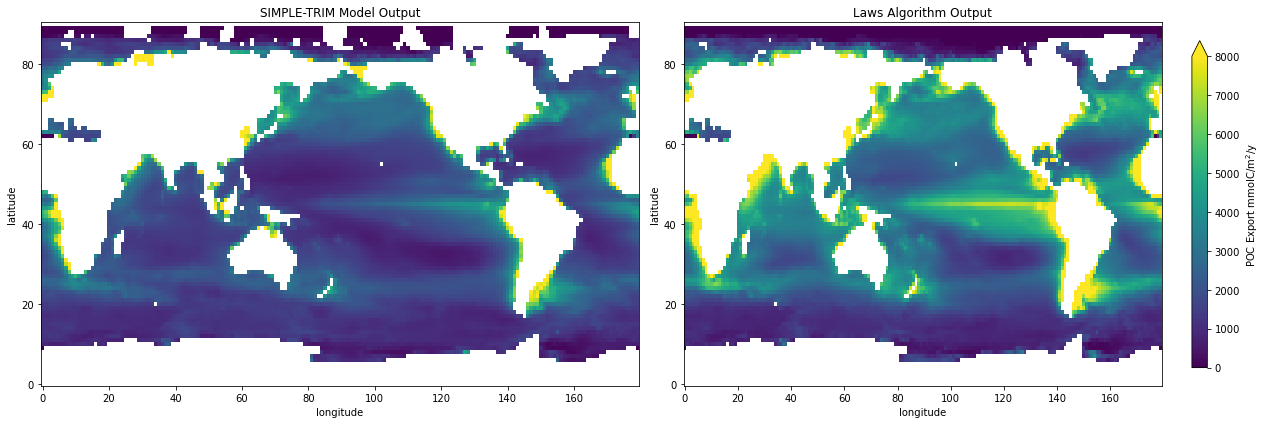

In [5]:
fix, ax = plt.subplots(figsize=(18, 6), ncols=2)
trim_export = trim.FPOCex.mean(axis=0).plot(x='longitude', y='latitude', vmin=0, vmax=8000, ax=ax[0], add_colorbar=False)
ax[0].set_title('SIMPLE-TRIM Model Output')

laws_plot = trim.laws.mean(axis=0).plot(x='longitude', y='latitude', ax=ax[1], vmin=0, vmax=8000, add_colorbar=False)
ax[1].set_title('Laws Algorithm Output')
cb = plt.colorbar(laws_plot, extend='max', shrink=0.9)
cb.set_label('POC Export mmolC/m$^{2}$/y')
plt.tight_layout()

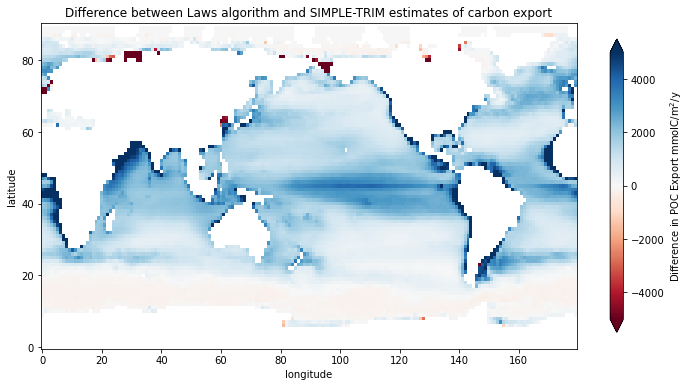

In [6]:
diff = trim.laws.mean(axis=0) - trim.FPOCex.mean(axis=0)
fix, ax = plt.subplots(figsize=(12, 6))
diff_plot = diff.plot(x='longitude', y='latitude', ax=ax, vmin=-5000, vmax=5000, add_colorbar=False, cmap='RdBu')

ax.set_title('Difference between Laws algorithm and SIMPLE-TRIM estimates of carbon export')
cb = plt.colorbar(diff_plot, shrink=0.9, extend='both')
cb.set_label('Difference in POC Export mmolC/m$^{2}$/y')

# Laws has higher estimates at low latitudes, especially in near margin regions and near the ITCZ
# SIMPLE-TRIM has higher estimates at high latitudes, especially in high latitude seas

## Load GEOTRACES GP16 TEI data

In [7]:
dropbox_url = 'https://dl.dropboxusercontent.com/s/e9u1bwz5d0izspe/GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1.nc?dl=0'

file_path = pooch.retrieve(url=dropbox_url,
                           known_hash='md5:82e4a35dd37b78474c8c30346b31387d')
file_path

'/home/jovyan/.cache/pooch/ed71d9f3b0cf0046dc6061e8860e4f9c-GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1.nc'

In [8]:
tei = xr.open_dataset(file_path)

tei = tei.rename({
    'N_STATIONS':'station',
    'N_SAMPLES':'depth',
    'metavar1':'cruise',
    'metavar2':'station',
    'var2':'z', 
    'var474':'Th230_TP',
    'var474_err':'Th230_TP_err',
    'var332':'Ba_TP',
    'var332_err':'Ba_TP_err',
    'var370':'Al_TP'
})

tei = tei.set_coords(['station', 'z', 'cruise'])
tei = tei.set_index(cruise='station')
tei


<xarray.Dataset>
Dimensions:       (cruise: 3149, station: 3149, depth: 698)
Coordinates:
  * cruise        (cruise) object b'0' b'1' b'2' b'3' ... b'12' b'13' b'15'
    z             (station, depth) float32 ...
Dimensions without coordinates: station, depth
Data variables: (12/1585)
    metavar3      (station) |S1 ...
    longitude     (station) float32 ...
    latitude      (station) float32 ...
    metavar4      (station) float32 ...
    metavar5      (station) |S13 ...
    metavar6      (station) |S20 ...
    ...            ...
    var582        (station, depth) float32 ...
    var582_qc     (station, depth) float32 ...
    var583        (station, depth) float32 ...
    var583_qc     (station, depth) float32 ...
    var584        (station, depth) float32 ...
    var584_qc     (station, depth) float32 ...
Attributes:
    Conventions:         CF-1.7
    comment:             ODV NetCDF Export File V2.0
    Creator:             rschlitz@BGEO04M097-1
    CreateTime:          2021-11-11T08:45:54
    Software:            Ocean Data View 5.5.2 - 64 bit (Windows)
    source:              C:/GEOTRACES/IDP2021/output/data/seawater/GEOTRACES_...
    SourceLastModified:  2021-11-09T15:31:14
    DataField:           Ocean
    DataType:            Profiles
    Description:         GEOTRACES IDP2021 seawater discrete sample hydrograp...
    featureType:         profile

In [9]:
tei.cruise

<xarray.DataArray 'cruise' (cruise: 3149)>
array([b'0', b'1', b'2', ..., b'12', b'13', b'15'], dtype=object)
Coordinates:
  * cruise   (cruise) object b'0' b'1' b'2' b'3' ... b'11' b'12' b'13' b'15'

In [10]:
#GP16_tei = tei.sel(cruise=b'9')
#GP16_tei = tei.sel(cruise='GP16')
#GP16_tei

## Calculate 230Th normalized particulate excess barium fluxes

$F(^{230}Th) =  \int_{0}^{z} (^{234}U * \lambda_{230}) \,dz \approx 0.000432z$ 

$pBa_{xs} = [Ba] - [Al](\frac{Ba}{Al})_{litho}$

$F(pBa_{xs}) = F(^{230}Th) * \frac{[pBa_{xs}]}{[^{230}Th]}$

In [11]:
Ba_Al_lith_mass = 0.004 # mass ratio
mwBa = 137.327 # amu
mwAl = 26.981539 # amu
Ba_Al_lith = Ba_Al_lith_mass * mwAl / mwBa # mol ratio

F230Th = 0.000432 * tei.z # Bq /m2 /y
pBaxs = tei.Ba_TP  - (Ba_Al_lith * tei.Al_TP * 1000)
FpBaxs = F230Th * pBaxs / tei.Th230_TP

#plt.plot(tei.latitude, FpBaxs)